# Assign 2: Linear Regression Lab

In this first lab you will fit a linear regression model. You will also dig deeper by 'training' a linear regression model manually in a few different ways. 

You might be wondering, "*why all the excitement about linear regression?*"  It so happens that regression is one of the workhorses of machine learning, and it also underlies other more complex types of models.  The advantage of regression models is that they are highly interpretable and very stable when it comes to training/fitting. In fact, linear regression models, particularly multiple linear regression with many input predictors, can mimic a lot of the power of more complex models, such as neural networks, while maintaining their computational stability and interpretability. There is a long running joke/meme about companies that claim to use "machine learning" actually use linear regression (and logistic regression, which we'll soon see more of). This isn't entirely a joke though since even if a company is using very powerful/complex types of models (e.g. deep neural networks), they will almost always have already tried using a linear regression model because it would be the cheaper and faster solution.  In other words, linear regression is almost always the default modeling approach, and is sometimes hard to beat!

*Note that this notebook uses some content from a [course at NYU](https://cims.nyu.edu/~brenden/courses/labincp/labs/LabReg-IntroToRegression.html), which itself borrowed content from [General Assembly's Data Science](https://github.com/justmarkham/DAT4) course, which claims to have adapted materials one of the most authoratative texts on the subject, [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/).*


Next, we would typically load the Python libraries/modules that we'll use. However, these have been commented because we will load each module individually just before we use it, so that we can start to understand which modules does what. 

In [4]:
from IPython.core.display import HTML, Markdown #, display
from sklearn import linear_model
import numpy.random as npr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf
import ipywidgets as widgets

ModuleNotFoundError: No module named 'statsmodels'

We are going to use the [statsmodels](https://www.statsmodels.org/stable/index.html) python package to fit our regression model because it has a lot of nice outputs which are helpful for interpreting regressions.  However, you could do almost all of the same using the [scikit-learn](https://scikit-learn.org/stable/) package, which is a more general package for machine learning than can perform various types of sophisticated regression, classification, clustering, and dimensionality reduction steps.

## Loading the dataset

Before training/fitting any model we need data. Below we will load a dataset from the text, [Learning Statistics with R](https://kpu.pressbooks.pub/learningstatistics/). The dataset will help us to explore the factors that lead to a parent being grumpy after having a baby.

The data is located in a public github repository but loading will be no different than if it were a local file in our computer. We simply use the link to the file and open it with the [pandas](https://pandas.pydata.org) Python module `read_csv` command. 

Also, let's look at the first few rows of data. Note that one row can be thought of as one *observation*. 

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/sgeinitz/CS3120/main/lab1_data_parenthood.csv')
df.head()

,day,parent_sleep,baby_sleep,parent_grumpy
0,1,7.59,10.18,56
1,2,7.91,11.66,60
2,3,5.14,7.92,82
3,4,7.71,9.61,55
4,5,6.68,9.75,67


For this dataset one observation consists of the following fields or columns:

* `day` - the day of the baby's life and the day that the observation was made  
* `parent_sleep` - number of hours of sleep the parent had the night before this day
* `baby_sleep` - number of hours of sleep the baby had the night before this day
* `parent_grumpy` - level of grumpiness of the parent on this day (this will be our `Y`, or what we will want to try to predict)

To confirm that information, or if we didnt' know it ahead of time, we could use the pandas dataframe method, `describe`, to see some descriptive statistics for each column. 

In [2]:
df.describe()

,day,parent_sleep,baby_sleep,parent_grumpy
count,100.000000,100.000000,100.000000,100.00000
mean,50.500000,6.965200,8.049200,63.71000
std,29.011492,1.015884,2.074232,10.04967
min,1.000000,4.840000,3.250000,41.00000
25%,25.750000,6.292500,6.425000,57.00000
50%,50.500000,7.030000,7.950000,62.00000
75%,75.250000,7.740000,9.635000,71.00000
max,100.000000,9.000000,12.070000,91.00000


***
### Q1: What does the column `parent_grumpy` look like? What is it's mean? What is it's minimum value? Maximum value? Based on all of that, what do you think the scale of grumpiness is? Is it between 1 and 10? Between -1 and 1?

It shows the average grumpiness of a parents scaling from 1 to 100. The minimum value is 41 while the maximum is 91, and it has a mean of 63.7.  
***

Next, let's look at if or how the columns are related to one another. There are descriptive statistics that we can calculate to do this but typically it's best to simply look at the data and see what it looks like. 

We'll use the Python module [seaborn](https://seaborn.pydata.org), which is for plotting and visualizing data. 

In [ ]:
import seaborn as sns

sns.scatterplot(data=df, x='day', y='parent_grumpy')

***
### Q2: Does there appear to be a relationship of any kind between day and how grumpy the parent is? In other words, does a parent's level of grumpiness get better or worse in the first 100 days of baby's life? Is there any type of pattern in how these two variables are related? 

\<input your answer here - note that you should justify your answer by describing what you see in the scatter plot above\>
***

Next, let's look at the other fields versus a parent's level of grumpiness. Note that we'll now use the other common Python module for plotting and visualization, matplotlib. This module is lower-level than seaborn which allows us to create multiple plots side by side, and manipulate other small details of plots. 

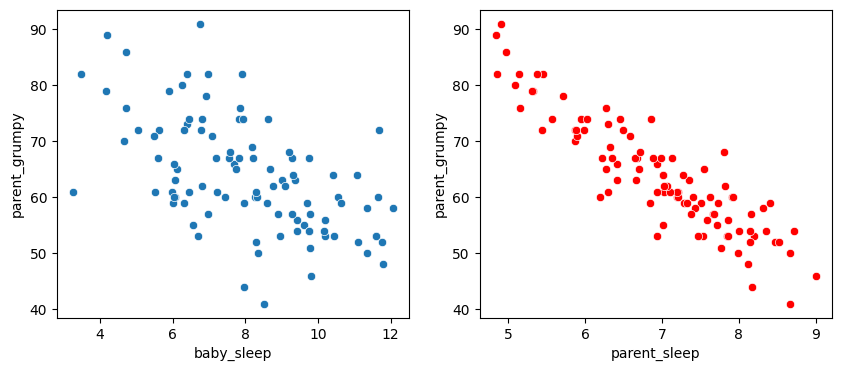

In [5]:
import matplotlib.pyplot as plt

#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(data=df, x='baby_sleep', y='parent_grumpy', ax=ax1)
sns.scatterplot(data=df, x='parent_sleep', y='parent_grumpy', ax=ax2, color='red')
#sns.scatterplot(data=df, x='baby_sleep', y='parent_sleep', ax=ax3, color='red')
plt.show()

***
### Q3: What is the relationship that seems more important here? In other words, which do you think is a more direct cause of a parent being grumpy? 

As the baby and the parents les less sleep, the more grumpy they tend to be, while they get more sleep the less grumpy they tend to be. The relationship that seems to be the most important with this dataset is the amount of sleep that both the parents and babies get and how it relates to their mood. 

***

## Simple Linear Regression

There is a lot more that could be discussed about which variable drives what, in what order, etc. For now though, let's go ahead and begin fitting a linear regression. As we've seen, simple linear regression is an approach for predicting a **quantitative response** using a **single feature** (or "predictor" or "input variable"). It takes the following form:

$y = \beta_0 + \beta_1x \quad $ or $ \quad y = b + w x$

What does each term represent?
- $y$ is the response
- $x$ is the feature
- $\beta_0$ is the y-intercept of the line, which we could also call the **bias** parameter, $b$
- $\beta_1$ is the slope of the line or coefficient for x, which we could also call the **weight** parameter, $w$

Together, $\beta_0$ and $\beta_1$, or $b$ and $w$ are called the **model coefficients**, or **parameters** of the model. To train or fit the model it must "learn" the values of these parameters. Once we've learned these coefficients, we can use the model to make predictions!

What do you mean by "learn"?  Well you are probably more familiar with the phrase "fit" meaning we adjust the settings of the model coefficients (aka as parameters) until the line seems like a good summary of the data.  Fitting thus mean adjusting some internal numbers so that the better reflect the underlying data set.  Well when a human (or machine) learns it, it is in some sense of the same thing.  We change the connections of the weights (or parameters) inside our brains to help us better predict our environment.  For instance if your roommate is prone to late night partying and being grumpy the next day you might mentally fit a model to the experiences you have and "learn" what features are predictive of them being grumpy.  So basically fitting a linear regression model is the same as doing basic machine learning! Wow!

Before we get into using the computer to "fit" our data, let's start simple and do things by hand. Try adjusting the sliders below to get to what you think is a good model fit. As mentioned in class, getting roughly half of the points above the line and half below the line is ideally what we want. 

In [6]:
from IPython.core.display import HTML, Markdown
import ipywidgets as widgets
import numpy as np

@widgets.interact(slope=widgets.IntSlider(min=-20, max=20, step=1, value=0), intercept=widgets.IntSlider(min=0, max=200, step=1, value=50))
def plot_grumpiness(slope, intercept):
    predict = intercept + slope * df.parent_sleep
    resid = df.parent_grumpy - predict
    fig, ax = plt.subplots(figsize=(9,6))

    x1 = np.linspace(df.parent_sleep.min(), df.parent_sleep.max(), 400)
    y1 = intercept + slope * x1

    ax.plot(df.parent_sleep, df.parent_grumpy, 'ko', markersize=4)

    ax.plot(x1, y1, '-', color='steelblue', linewidth=1)
    plt.xlabel("dad sleep")
    plt.ylabel("dad grumpy level")

    plt.show()


ModuleNotFoundError: No module named 'ipywidgets'

If you used the approach of getting half of the points above the line and half below the line, you probably realized that there are several different ways to acheive this - not all of which make sense. That's why we instead think about fitting a regression model as minimizing all **residuals**. A residual is defined as the difference between the the observation $y$ and the prediction $\hat{y}$. 

Specifically, the **residual for the $i^{th}$ observation** in the data is defined as:
* $y_i - \hat{y}_i$

The next plot shows what are known as the **residuals** between the actual data points (black) and the regression line (blue). As you can see the total amount of red changes depending on how good of a fit your parameter values give you. Use this widget to make your own *guesstimate* of what the values of $\beta_0$ and $\beta_1$ should be. 


In [ ]:
@widgets.interact(slope=widgets.IntSlider(min=-20, max=20, step=1, value=0), intercept=widgets.IntSlider(min=0, max=200, step=1, value=50))
def plot_grumpiness(slope, intercept):
    predict = intercept+slope*df.parent_sleep
    resid = df.parent_grumpy-predict
    fig, ax = plt.subplots(figsize=(9,6))

    x1 = np.linspace(df.parent_sleep.min(), df.parent_sleep.max(),400)
    y1 = intercept+slope*x1

    ax.plot(df.parent_sleep, df.parent_grumpy,'ko',markersize=4)
    ax.plot(df.parent_sleep, df.parent_grumpy-resid,'o',markersize=4,markeredgecolor='r', markeredgewidth=.4, markerfacecolor='white')

    ax.plot(x1,y1,'-',color='blue',linewidth=1)
    plt.xlabel("dad sleep")
    plt.ylabel("dad grumpiness")

    ax.vlines(df.parent_sleep, df.parent_grumpy, df.parent_grumpy-resid,'r',linewidth=0.5)
    plt.show()



***
### Q4: What values of $\beta_0$ and $\beta_1$ result in a good model fit? Is the slope positive or negative? Explain why?

\<input your answer here\>

***

## Estimating Model Coefficients (i.e. "training" the model)

The mechanics of fitting a line to some data, or "learning" the model parameter values, or "training" the model is better done using a precise method rather than eyeballing it as you did above. Generally speaking, coefficients are estimated using the **least squares criterion**, which means we will find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors"). This can be summed up in the following graphic.

![toyexample](https://cims.nyu.edu/~brenden/courses/labincp/_images/08_estimating_coefficients.png)

In the figure above...
- the black dots are the **observed values** of x and y,
- the blue line is the **least squares line**,
- the red lines are the **residuals**, which are the distances between the observed values and the least squares line.

Remember, model parameters in the regression model can be interpreted as follows. 
- $\beta_0$ is the **intercept** (the value of $y$ when $x$=0)
- $\beta_1$ is the **slope** (the change in $y$ divided by change in $x$)

Here is a graphical depiction of those calculations:

![toyexample2](https://cims.nyu.edu/~brenden/courses/labincp/_images/08_slope_intercept.png)


To find the best possible parameter values (i.e. to fit or train the model), we want to minimize the sum of squared errors. Note that since $\hat{y}$ is a function of $\beta_0$ and $\beta_1$, then the sum of squared errors can be stated as a function of them (and then minimized). Namely, we want to minimize the following expression with respect to $\beta_0$ and $\beta_1$.

* $\sum_{i=1}^{n} (y_i - (\beta_0 + \beta_1 x_i))^2$

We could manually calculate the values by minimizing the above, but let's first use the [statmodels](https://www.statsmodels.org/stable/install.html) Python package. See how these numbers compare to the values you found in your *guesstimate* above.

In [ ]:
import statsmodels.formula.api as smf

sm_lm = smf.ols(formula='parent_grumpy ~ parent_sleep', data=df).fit()
print(sm_lm.params)

A couple of points on how we used `smf` here... 
* First is that we use the `smf.ols()` function which does an _ordinary least squares_ fit.  This is the type of fit which tries to minimize the sum of the squared residuals.  There are other types of fitting proceedures such as weighted least squares which is used when you expect the variance of the predicted variable to changes with the input predictor as well as its mean value.  We won't worry about those variations of linear regression in this class though. 

* Second is that we provide the `ols()` function or method with the pandas dataframe we are working with, `df`, and then provide a formula.  The formula expresses our "_model_" and is which variables in the data frame we are trying to relate.  Here the formula `parent_grumpy ~ parent_sleep` means that we want to predict `parent_grumpy` values given `parent_sleep` values. So you think of `parent_grumpy` as our "_y value_" and `parent_sleep` are our "_x value_". 


Although the **statsmodels** Python module is a powerful and intuitive tool for statistics, and similar to the standard libraries in R, the module that is more common among Data Scientists and Machine Learning practioners is [scikitlearn](https://scikit-learn.org/stable/). We'll use this now. Try to make a note of how the syntax is different between statsmodels and scikitlearn. 

In [ ]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
lm.fit(df[['parent_sleep']], df['parent_grumpy'])
print(lm.coef_, lm.intercept_)

It's easy to see that the values of the parameters for both models are the same, but notice the small diffences in the names of usage of them. The **statsmodel** model gives us all of the parameters in attribute `lm.params`. 

With `scikitlearn`, or `sklearn` above, the model has different attributes for each parameter, `lm.coef_`, `lm.intercept`. Note that `lm.coef` itself is a list though, so if our model was going to have other predictors, i.e. other X variables or inputs, then they would be added to the list, `lm.coef`. 

## Interpreting the Model

One of the biggest advantages of ordinary least squares regression is that it is highly interpretable. By this, we mean to say that it's possible to look at the model parameter values and directly draw some conclusion or interpretion from it. 

That is, we can directly interpret the `slope` or `weight` parameter associated with `parent_sleep`, according to its value. In this case, with a value of `-8.9`, we can say:

- A one "unit" increase in hours of sleep is associated with a -8.9367 "unit" decrease (because it is negative) in grumpiness. This should kind of make sense once you think about it too, i.e. more sleep = less grumpy!

The other parameter in our model, the `intercept` or `bias` term, tells us what the model would predict if `X`, or `parent_sleep` in this case, were zero (0). (You can sort understand why it is referred to a bias term also, since it's the value you would get if you didn't have any information, so it's sort of a presupposed value, or bias.)
If `parent_sleep` is zero, then `pare
nt_grumpy` would be predicted to be 125.95. This means that if a parent gets no sleep at all their grumpiness will be at a very high level of 125.95!  Bad news.

***
### Q5: Suppose that the _grumpiness_ scale is between 0 and 100. How would you explain or justify the prediction the model would make if a parent did not sleep at all the night before? Or, if they slept only one hour? What does this say about the model, is it a "good" or "bad" model?

\<input your answer here - and explain \>

***

Note that this question is related to a famous saying in Statistics, which is "*All models are wrong, but some are useful*". This essentially says that every model has limitations, or is incorrect in some way, but can still make sense and yield useful results when used in the appropriate setting. 

![image](https://miro.medium.com/v2/resize:fit:1400/1*EJZZKiXLcbp_MxRW9HJrmA.jpeg)

## Using the Model for Prediction

Once the model has been fit or trained with the training data, we can now use it for predictions. In other words, with just the following equation it is possible to make a prediction for any new value of `x`, i.e. `parent_sleep`.
$$y = 125.956292 + -8.936756 \times x$$

***

### Q5: Using only the trained model the parent now wants to make a prediction for tomorrow. Everything is going smooth so they antipicate getting a good night of sleep, or around `8.5` hours of sleep. What will their predicted level of grumpiness be tomorrow? 

\<modify the following code cell to find your answer then input your answer here\>

***

In [ ]:
hours_of_sleep =
X_new = pd.DataFrame({'parent_sleep': [hours_of_sleep]})
lm.predict(X_new)

## Plotting the least squares regression line

Let's take a look at the best fit line.  There are two very easy ways to do this.  One is using seaborn's regplot which takes care of all of the underlying steps to plot the regression line. 

In [ ]:
sns.regplot(x='parent_sleep', y='parent_grumpy', data=df)

Alternatively, if we want more control over the plot, or want to make other modifications, then using matplotlib is often going to be preferred. 

In [ ]:
fig, ax = plt.subplots(figsize=(6.5,4))

# create a DataFrame with the minimum and maximum values of sleep
x1 = pd.DataFrame({'parent_sleep': [df.parent_sleep.min(), df.parent_sleep.max()]})
y1 = lm.predict(x1)  # predict for the two data points using the fitted model in lm
ax.plot(df.parent_sleep, df.parent_grumpy, 'ko', markersize=4)
ax.plot(x1, y1, '-', color='steelblue', linewidth=1)
plt.xlabel("parent_sleep")
plt.ylabel("parent_grumpy")
plt.show()

## Confidence in our Model

As mentioned before, the **statsmodels** library offers some convience for more traditional statistics questions or tasks. One of those is getting an idea of how confident we are about the estimated values of the parameters. Looking at the confidence intervals for the parameter value estimates gives us a decent idea of whether the model fits this data reasonably well. Below we look at the 95% confidence interval, or the $(1-\alpha)$% confidence interval. 

As you can see, although there is a range of possible values, the range is reasonably small, telling us that there is a high level of confidence these parameter values estimates are yielding a model that fits the data reasonably well. We have to be careful not to misinterpret this though, remember that the precise intrepretation of the confidence interval is... 

* If the population from which this sample was drawn was **sampled 100 times**, approximately **95 of those confidence intervals** would contain the "true" coefficient.

In [ ]:
# print the confidence intervals for the model coefficients
sm_lm.conf_int(alpha=0.05)

Since the **sklearn** package tends to take more of a machine learning approach it does not have some of the same functionality as statsmodels. However, with a few more steps, it is possible to calculate. It's possible though, and you should verify that the confidence intervals are the same as above. 

In [ ]:
# needs the stats module for getting appropriate t-values
from scipy import stats

def get_conf_int(alpha, lr, X, y):    
    coefs = np.r_[[lr.intercept_], lr.coef_]
    X_aux = X.copy()
    X_aux.insert(0, 'const', 1)
    dof = -np.diff(X_aux.shape)[0]
    mse = np.sum((y - lr.predict(X)) ** 2) / dof
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    t_val = stats.t.isf(alpha/2, dof)
    gap = t_val * np.sqrt(mse * var_params)

    return pd.DataFrame({
        'lower': coefs - gap, 'upper': coefs + gap
    }, index=X_aux.columns)

get_conf_int(0.05, lm, df[['parent_sleep']], df['parent_grumpy'])

In [ ]:
np.diff(df.shape)

Again, remember that we only have a **single sample of data**, and not the **entire population of data**. The "true" coefficient is either within this interval or it isn't, but there's no way to actually know. We estimate the coefficient with the data we do have, and we show uncertainty about that estimate by giving a range that the coefficient is **probably** within.

Also note that using 95% confidence intervals is just a convention. We could create 90% confidence intervals (which will be more narrow), or 99% confidence intervals (which will be wider), or whatever intervals we think make the most sense for our analysis/task. 

## Hypothesis Testing and p-values

Closely related to confidence intervals is **hypothesis testing**. Generally speaking, we start with a **null hypothesis** and an **alternative hypothesis** (that is opposite the null). Then, we check whether the data supports **rejecting the null hypothesis** or **failing to reject the null hypothesis**.

(Note that "failing to reject" the null is not the same as "accepting" the null hypothesis. The alternative hypothesis may indeed be true, except that we just don't have enough data to show that.)

As it relates to model coefficients, here is the conventional hypothesis test:
- **null hypothesis:** There is no relationship between dad sleep and grumpiness (and thus $\beta_1$ equals zero)
- **alternative hypothesis:** There is a relationship between dad sleep and dad grumpinss (and thus $\beta_1$ is not equal to zero)

In [ ]:
# print the p-values for the model coefficients
sm_lm.pvalues

How do we test this hypothesis? Intuitively, we reject the null (and thus believe the alternative) if the 95% confidence interval **does not include zero**. That is generally much easier to intrepret than the p-value, which strictly speaking should be interpreted as follows:
* If the null hypothesis is true, then the p-value is probability of observing the data that we did (and thus getting the model parameters that we did). 

In this case, since the the p-values are both so small, we can likely safely reject the null hypothesis in favor of the alternative. 

Note that we generally ignore the p-value for the intercept. So, focusing only on the model parameter associated with `parent_sleep`, and seeing a p-value far less than 0.05, we can conclude that there is a relationship between sleep and grumpiness.

## How Well Does the Model Fit the data?

The most common way to evaluate the overall fit of a linear model is by the **R-squared** value. R-squared is calculated in such a way that it has the direct intrepretation of being the **proportion of variance explained**, meaning the proportion of variance in the observed data that is explained by the model, or the reduction in error over the **null model**. (The null model just predicts the mean of the observed response, and thus it has an intercept and no slope.)

R-squared is between 0 and 1, and higher is better because it means that more variance is explained by the model. Here's an example of what R-squared might be for different models fit to the same dataset (but a different data than our parenthood data).

![polyfits](https://github.com/sgeinitz/CS3120/blob/main/images/poly_fits.png?raw=true)

You can see that the **blue line** explains some of the variance in the data (R-squared=0.54), the **green line** explains more of the variance (R-squared=0.64), and the **red line** fits the training data even further (R-squared=0.66). (No need to think about this too hard right now, but which of those possible 

Getting back to our parenthood datset, let's now calculate the R-squared value for our simple linear model. 

In [ ]:
sm_lm.rsquared

It's difficult to say what "_good_" R-squared value is. The threshold for a good R-squared value will depend widely on the domain and data. Therefore, it's most useful as a tool for **comparing different models**, rather than as saying that a single model is "_good_". 

Up until now we have been pulling information from the fitted model piece by piece. However, there is a nice summary command with **statsmodels** that lets you access a bunch of information about your regression at once. Don't worry about all of the other statistics and details listed there, just know that almost all of the information you'll ever need about a linear regression model can be found there. 

In [ ]:
sm_lm.summary()

## Training a Linear Regression Manually

We saw how easy it is to use Python to fit (i.e. train) a linear regression model. Let's go ahead and confirm that the manual approaches we've seen, and the intuition behind them also make sense. 

Most often we'll see a linear regression defined for one $i^{th}$ observation or training example. Which, for the feature $x_i$ and outcome $y_i$, is written as:
$$y_i = \beta_0 1 + \beta_1 x_i$$

However, we also saw that this can be written in vector or matrix notation where the matrix, $X$, has a column of 1's in it.
$$\vec{y} = X \vec{\beta}$$
where
$$\vec{\beta} = \begin{bmatrix}\beta_0 \\ \beta_1\end{bmatrix}$$
Then, since (or if) the columns of the matrix $X$ are linearly independent, then the matrix $(X^T X)$ has an inverse, and the model parameters can be calculated directly using:
$$\vec{\beta} = (X^T X)^{-1} X^T \vec{y}$$

Let's now confirm this works using the parenthood data. We'll first create the matrix $X$, being sure to add a $1$ column since that is needed to estimate $\beta_0$. 
 

In [ ]:
X = pd.DataFrame({'intercept': 1, 'parent_sleep': df.parent_sleep})
X.head(n=3)

Let's now do all of the remaining calculations, one step at a time. 

In [ ]:
# Calculate X^T X
XtX = np.dot(X.T, X)

# Then the inverse of X^T X
XtX_inv = np.linalg.inv(XtX)

# Then X^T y
Xty = np.dot(X.T, df.parent_grumpy)

# And lastly the coefficients
betas = np.dot(XtX_inv, Xty)
betas

While the linear algebra approach is useful for understanding the underlying math from another point of view, it not immediately intuitive why it works. The following diagram is maybe the best attempt at trying to explain the intuition behind this linear algebra approach. 

![projection](https://github.com/sgeinitz/CS3120/blob/main/images/projection.png?raw=true)

That image is telling us that the any prediction coming out of our model is going to be in the column space of $X$ (i.e. it will lay in a space that spanned by all possible linear combinations of the columns of $X$.) It is not super important that you know this, but it's a fun alternative way to see how linear regression models are fit to their data. 

The more intuitive way to explain how we fit a linear regression model is by looking more precisely at that quantity we want to minimize, namely the SSE:
$$\text{SSE} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Recall that since $\hat{y}_i$ is a the prediction for the $i^{th}$ observation, we can write it as $\beta_0 + \beta_1 x_i$, and thus rewrite SSE as:
$$\text{SSE} = \sum_{i=1}^{n} \left(y_i - (\beta_0 + \beta_1 x_i)\right)^2$$

Since there are two parameters, $\beta_0, \beta_1$, it's easy for us to visualize what the SSE looks like as a function of these two parameters. Below is a heatmap or surface plot of these. Again, to train the model we need to find the model parameter values that minimize SSE. Look at the plot below to see if you can roughly guess what the parameter values are. 

In [ ]:
beta0_range = 25
beta0 = np.arange(lm.intercept_+beta0_range, lm.intercept_-beta0_range, -0.5)
beta1_range = 4
beta1 = np.arange(lm.coef_[0]-beta1_range, lm.coef_[0]+beta1_range, 0.1)
surf = np.array( [[np.square(df.parent_grumpy - (beta0[i] + beta1[j]*df.parent_sleep)).sum() for j in range(len(beta1))] for i in range(len(beta0))] )
df_surf = pd.DataFrame(surf, columns=beta1, index=beta0)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_surf, cbar_kws={'label': 'SSE'}, cmap="RdYlGn_r", ax=ax)
ax.contour(np.arange(.5, df_surf.shape[1]), np.arange(.5, df_surf.shape[0]), df_surf, colors='black', levels=[1960, 9000, 50000, 150000], linewidths=0.5)

plt.xlabel("beta1")
plt.ylabel("beta0")
plt.show()


You probably already figured out how to find the parameter values above, which is to look at the values of $beta_0$ and $\beta_1$ that corresponded to the lowest point on the surface. We can look the data used in the plot and see here. 

In [ ]:
# find the minimum of the surface
beta0_min, beta1_min = np.unravel_index(surf.argmin(), surf.shape)
beta0[beta0_min], beta1[beta1_min]

Notice that those values are nearly exactly what we found using **statsmodels**, **sklearn**, as well as the linear algebra approach. Let's try one more way of finding these parameter values now. For this we'll use calculus to solve for values of $\beta_0$ and $\beta_1$ that give us the minimum on the surface above (i.e. the value where the slope of the surface is zero).

If you recall from Calculus class, we simply need to write the SSE as a function of the model parameters, $\beta_0$, $\beta_1$, and set it to zero, then solve. It's not important that you know how to do this exactly, but it's important to know that this is yet another way to think about "_training_" a linear regression model. Let's first explicitly state that the SSE is a function of the model parameters:
$$\text{SSE}(\beta_0, \beta_1) = \sum_{i=1}^{n} \left( y_i - (\beta_0 + \beta_1 x_i) \right)^2$$


Steps to Solve for $\beta_0$ and $\beta_1$ Using Calculus

1. Partial Derivatives
   - To minimize SSE, take the partial derivatives of SSE with respect to $\beta_0$ and $\beta_1$, and set them equal to zero.

   Partial Derivative with respect to $\beta_0$:
   $$\frac{\partial \text{SSE}}{\partial \beta_0} = \sum_{i=1}^{n} -2 \cdot \left( y_i - \beta_0 - \beta_1 \cdot x_i \right) = 0$$

   Partial Derivative with respect to $\beta_1$:
   $$\frac{\partial \text{SSE}}{\partial \beta_1} = \sum_{i=1}^{n} -2 \cdot x_i \cdot \left( y_i - \beta_0 - \beta_1 \cdot x_i \right) = 0$$

2. Simplify the Equations
   - Simplify the partial derivative equations to form two normal equations.

   For $\beta_0$:
   $$\sum_{i=1}^{n} \left( y_i - \beta_0 - \beta_1 \cdot x_i \right) = 0$$
   - Expanding and beginning to isolate $\beta_0$, we get:
   $$\sum_{i=1}^{n} y_i - n \cdot \beta_0 + \beta_1 \sum_{i=1}^{n} x_i = 0 \quad \rightarrow \quad n \cdot \beta_0 = \sum_{i=1}^{n} y_i -\beta_1 \cdot \sum_{i=1}^{n} x_i $$
   - Divide by $n$ to get:
   $$\beta_0 = \bar{y} - \beta_1 \cdot \bar{x}$$
   where $\bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i$ and $\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i$ are the means of $y$ and $x$, respectively.

   For $\beta_1$:
   $$\sum_{i=1}^{n} x_i \cdot y_i = \beta_0 \cdot \sum_{i=1}^{n} x_i + \beta_1 \cdot \sum_{i=1}^{n} x_i^2$$
   - Substitute $\beta_0 = \bar{y} - \beta_1 \cdot \bar{x}$ into this equation:
   $$\sum_{i=1}^{n} x_i \cdot y_i = (\bar{y} - \beta_1 \cdot \bar{x}) \cdot \sum_{i=1}^{n} x_i + \beta_1 \cdot \sum_{i=1}^{n} x_i^2$$
   - After expanding and simplifying:
   $$\beta_1 = \frac{\sum_{i=1}^{n} \left( x_i - \bar{x} \right) \left( y_i - \bar{y} \right)}{\sum_{i=1}^{n} \left( x_i - \bar{x} \right)^2}$$

Let's now use these formulas to "train" the model (i.e. calculate the values of the parameters $\beta_0$, $\beta_1$) for our given training dataset.


In [ ]:
n = df.shape[0] # this is the number of observations or training examples
b1_numerator = np.sum((df.parent_grumpy - df.parent_grumpy.mean()) * (df.parent_sleep - df.parent_sleep.mean()))
b1_denominator = np.sum((df.parent_sleep - df.parent_sleep.mean()) ** 2)
beta1_hat = b1_numerator / b1_denominator

beta0_hat = df.parent_grumpy.mean() - beta1_hat * df.parent_sleep.mean()
(beta0_hat, beta1_hat)

As you can see, those values are the exact same as we found earlier. You may have noticed that the formulas we found for $\beta_0$ and $\beta_1$ above contain some terms that look similar to variance and covariance calculations. Given that, we could also calculate these values in a more concise manner using **numpy's** functions for these descriptive statistics. 

In [ ]:
cov = np.cov(df.parent_sleep, df.parent_grumpy, ddof=0) # calculate the covariance of x=df.parent_sleep and y=df.parent_grumpy
var_x = np.var(df.parent_sleep, ddof=0) # calculate the variance of x=df.parent_sleep

beta1_hat = cov[0,1] / var_x
beta0_hat = df.parent_grumpy.mean() - beta1_hat * df.parent_sleep.mean()
(beta0_hat, beta1_hat)

Hopefully it is somewhat satisfying to see that regardless of the approach we used, we still come up with the same model fit (i.e. the model parameters have the same values). We won't look at them here, but there are even more ways to state these formulas, including with the correlation between $x$ and $y$.

Next, let's assume that when the data was collected, the amount of sleep a parent had was recorded in minuts. The cell below creates this column, `parent_sleep_minutes`. Use this for the following question. 

In [ ]:
df['parent_sleep_minutes'] = df['parent_sleep']*60
df.parent_sleep_minutes.describe()

 ***
 
 ### Q6: Fit a new linear regression model with **statsmodels** where `parent_sleep_minutes` is used to predict `parent_grumpy`. Does this affect the model parameter estimates? Are they the same? Or different?

 \<modify the code in the cell below and modify it to fit the linear regression model and retrieve the model summary. Then input your here - be sure to state what the grumpiness value the model predicted\>

 ***

In [ ]:
sm_lm_min = smf.ols(formula=' ~ ', data=df).fit()
sm_lm_min.params

***

### Q7: Does having `parent_sleep` measured in different units affect how well the model fits the data? In other words, is the $R^2$ different from when `parent_sleep` was measured in hours? Also, are the p-values associated with $\beta_0$, $\beta_1$ different? What does this tell you about how linear regression models are affected by a variable being scaled? 

\<insert a code cell below then use `sm_lm_min.summary()` to retrieve the model summary and then input your answer here\>

***

### Multiple Linear Regression

What we've looked at so far is commonly referred to as *Simple Linear Regression*, which is when there is one *predictor* (or *feature* or *independent variable*), $x$, and we are trying to predict the *outcome* or *response* or *dependent variable*, $y$. Linear Regression is a powerful and commonly used tool though, so you can imagine that it's not too difficult to add more predictors. Below is an example where we'll try fitting a *Multiple linear Regression* model, which is a linear regression model with more two or more *predictors* (or *features* or *independent variables*).

The dataset is a (hypothetical) company's advertising spend and sales they have made for each day. There are four columns in the data:
* `tv` - amount of money spent on television advertising last week
* `radio` - amount of money spent on radio advertising last week
* `newspaper` - amount of money spent on newpaper advertising last week
* `sales` - number of widgets (in thousands) the company sold last week

In [ ]:
df_adv = pd.read_csv('https://raw.githubusercontent.com/sgeinitz/CS3120/main/lab1_data_advertising.csv')
df_adv.head()

Let's also get a quick idea of what the data looks like in terms of min, max, mean, etc.

In [ ]:
df_adv.describe()

*** 

 ### Q8: As we said, any data analysis or modeling task first requires looking at or visualizing the data. Plot the each of the independent variables (`tv`, `radio`, `newspaper`) against the dependent variable, `sales`. Then state which of them you think looks like it going to best predict `sales`. 

\<modify the code cell below (the first is done for you) and then input your answer here\>

***

If you can, try to put all of the plots together in a single figure. 

In [ ]:
# plot all three of the features against sales
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=df_adv, x='tv', y='sales', ax=ax1)
sns.scatterplot(data=df_adv, x='radio', y='sales', ax=ax2)
sns.scatterplot(data=df_adv, x='newspaper', y='sales', ax=ax3)
plt.show()


Next, let's fit a linear regression model using all three variables. 

In [ ]:
lm_adv = smf.ols(formula='sales ~ tv + radio + newspaper', data=df_adv).fit()
lm_adv.summary()

It looks like that model fits pretty well. But, based on the plots you saw above, it looks like there is not an exact linear relationship between `tv` and `sales`...

***

### Q9: Try fitting a model to this dataset with `radio` and `newspaper` included, but use the square root of `tv`. Then print the summary of the model to see the $R^2$. If you worked for this company, which model do you think you would use? The one above or this new one you created here? Explain why. 

\<fix the code cell below to fit the model described above and then input your answer here>

***

Hints:
* Use [this reference](https://www.statsmodels.org/dev/example_formulas.html#functions) to see how to include a function of an independent variable in your model
* The function, `np.sqrt( )` is numpy's square root function 

In [ ]:
lm_adv = smf.ols(formula='sales ~ ', data=df_adv).fit()
lm_adv.summary()

Nice work completing this notebook. If you didn't already appreciate the power of linear regression, hopefully this helped convince you in some way. Even though we will use lots of other types of models, you will almost always want to start with linear regression because of its simplicity, stability, and flexibility. We'll always want to use the *right model for the task at hand* though, so we probably don't want to be too much like either of the people below :) 

![Example Image](https://media.licdn.com/dms/image/v2/D4E22AQFLVt8372oIQA/feedshare-shrink_800/feedshare-shrink_800/0/1710511681665?e=1727308800&v=beta&t=XephAeg6t9otHgyXtIHxbYiAxJdKOkH0uP0pU9eP2oY)
